In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from data.metrics import recall
from visualization.plot_utils import write_latex_table, summary_pooling_table, pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features.tracks_info import TrackInfo
from collections import OrderedDict
from itertools import product
from data_utils import product_size
import matplotlib.pyplot as plt
import seaborn as sns

def pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    r_t = recall(true_t, pool_t)
    r_a = recall(true_a, pool_a)
    return OrderedDict([('pid',pid),('k',k),('strat',strat),('n',n_pick),('recall_tracks',r_t),('recall_artist',r_a)])

plot_settings()
pandas_settings()

# create pooling model

In [4]:
from models.word2vec_pooler import W2VPooler

pooler =  W2VPooler(verbose=True)
tracks = TrackInfo(subset='5k-')
list_s = [('The Scientist','Coldplay'),('Immigrant Song','Led Zeppelin'),('T.N.T.','AC/DC')]
from sklearn.cluster import k_means
seeds_t = [tracks.track_info2uris(tname,aname)[0] for tname,aname in list_s]
pool, dist= pooler.recommend(seeds_t,n=500,agg_strat='mean')

Found 3 out of 3 vecs
Averaging representation, returning pool of size 500


# test over metrics
## one playlist

In [5]:
k=25
pid = 2
n_pick = 100
strat='medoids' # there are many sampling strategies
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
display(pd.DataFrame([pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a)]))

Found 25 out of 25 vecs
4-medoids , returning pool of size 100


,pid,k,strat,n,recall_tracks,recall_artist
0,2,25,medoids,100,0.18,0.23


## how large does n have to be?

In [6]:
k=25
pid = 10
n_pick = 100000
strat='medoids'
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
# acrue results for k
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_pick,2500))
stats=[]
for i in pool_range:
    stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
stats_df = pd.DataFrame(stats)
stats_df.head()

Found 25 out of 25 vecs
4-medoids , returning pool of size 100000


,pid,k,strat,n,recall_tracks,recall_artist
0,10,25,medoids,25,0.00,0.04
1,10,25,medoids,125,0.00,0.04
2,10,25,medoids,225,0.00,0.06
3,10,25,medoids,325,0.00,0.09
4,10,25,medoids,425,0.00,0.09


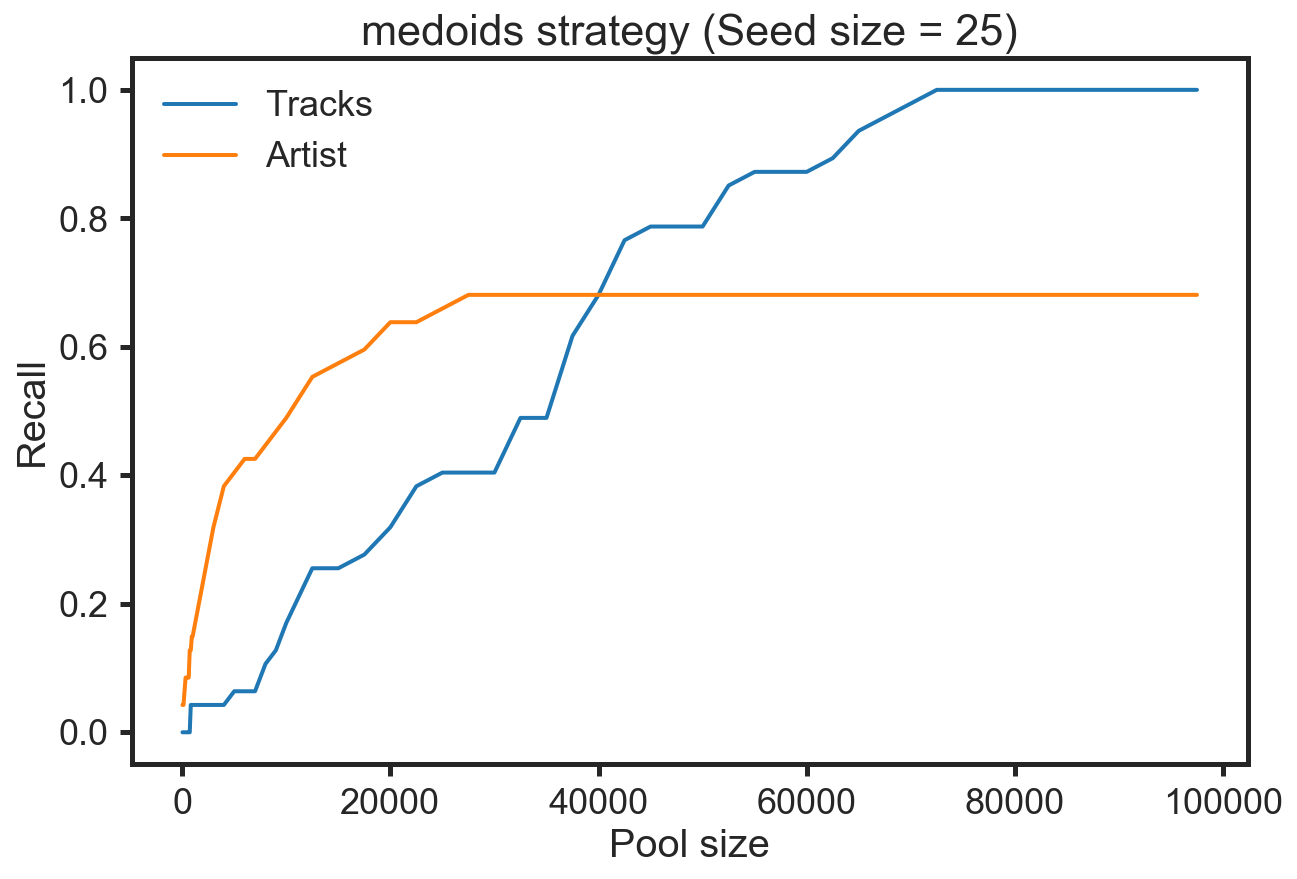

In [7]:
import matplotlib.pyplot as plt
plt.plot(stats_df['n'],stats_df['recall_tracks'],label='Tracks')
plt.plot(stats_df['n'],stats_df['recall_artist'],label='Artist')
plt.ylabel('Recall')
plt.xlabel('Pool size')
plt.title('{} strategy (Seed size = {})'.format(strat,k))
plt.legend()
plt.show()

# several random playlists

In [8]:
pooler.verbose=False
ks = [5, 10, 25, 100]
stats=[]
pids = [i for i in np.random.randint(0,5000,250)]
n_picks = [1000]
strats=['mean','centroids','medoids','split']
product_n = product_size([ks,pids,n_picks,strats])
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            stats.append(pool_stats(pid,k,strat,i,true_t,pool_t,true_a,pool_a))
    except ValueError as e:
        print('Error with {}'.format(combo))

  6%|▌         | 220/4000 [00:09<02:51, 22.03it/s]/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

  6%|▌         | 220/4000 [00:20<05:43, 11.00it/s]

## Results

In [ ]:
summ_df = summary_pooling_table(stats)
write_latex_table(summ_df,'pooling')
display(summ_df)
pooling_plots(stats)

# How big of a pool do we need (on average)?

In [ ]:
pooler.verbose=False
ks = [100]
stats=[]
pids = [i for i in np.random.randint(0,5000,100)]
n_picks = [25000]
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_picks[0],2500))
strats=['mean','centroids','medoids','wcentroids','wmedoids','split']
product_n = product_size([strats,n_picks,pids,ks])
stats=[]
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            for i in pool_range:
                stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
    except ValueError as e:
        print('Error with {}'.format(combo))
# random test
for combo in product(*[pids,ks]):
    pid,k = combo
    pl_turi,pl_auri = tracks.get_playlist(pid)
    if len(pl_turi) > k:
        seeds_t = pl_turi[:k]
        true_t,true_a = pl_turi[k:],pl_auri[k:]
        for i in pool_range:
            pool_t,pool_a = tracks.random_tracks(i,exclude=seeds_t)
            stats.append(pool_stats(pid,k,'random',i,true_t,pool_t,true_a,pool_a))

stats_df = pd.DataFrame(stats)
stats_df.head()

## results

In [ ]:
sns.factorplot(x="n", y="recall_tracks", hue="strat", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Track)')
plt.xlabel('Pool size')
plt.show()
sns.factorplot(x="n", y="recall_artist", hue="strat", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2,alpha=0.75)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Artist)')
plt.xlabel('Pool size')
plt.show()